# Abstract

This project aims to explore the concept of Semantic Image Segmentation using the U-Net architecture. Semantic segmentation is a critical task in computer vision that involves classifying each pixel in an image to a specific class. U-Net, a type of Convolutional Neural Network (CNN), is particularly effective for this task due to its ability to capture context and localization information.

# Introduction

Our objective is to explore the inner workings of the U-Net model by examining the feature maps generated at different stages of the network. We dissect the encoding, decoding, skip connection, and activation layers to gain insights into how the model learns to segment images pixel-wise. By visualizing the feature maps at each step, we aim to unravel the intricate process by which U-Net performs semantic segmentation, shedding light on its ability to accurately delineate objects and regions of interest within an image. Through this exploration, we seek to enhance our understanding of semantic segmentation and its practical applications in computer vision tasks.

## Resources and Tools

For this project, we used the Kitti Semantic RGB dataset for training the U-Net model. The dataset consists of 200 labeled images, out of which 140 images were used for the training set and 60 images were used for the validation set. The U-Net model was trained to classify images into a total of 30 classes.

Once the model was trained, we extracted the features of each layer using code inspired by a specific blog post. This allowed us to examine the feature maps generated at different stages of the network, providing insights into the inner workings of the U-Net model.

- Training pipeline is adapted from [ika-acdc-notebooks](https://github.com/ika-rwth-aachen/acdc-notebooks/tree/8afe3197db454e2aabd381fb5fc7d22a98f2b23f)
- Feature map extraction code is inspired by [this blog](https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/)
- Dataset: [Kitti Semantic Dataset](https://www.cvlibs.net/datasets/kitti/eval_semseg.php?benchmark=semantics2015)
- Model: U-Net, as described in this [paper](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/)


#### Necessary Imports

In [1]:
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
import random
import glob

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate

from segmentation_utils.metrics import SparseMeanIoU

random.seed(123)

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 12)

## Dataset

Kitti semantic dataset contains 200 images, for training purpose, 140 images are used as train set and 60 images as validation set. 

The dataset provides both semantic and semantic_rgb annotation. for this project semantic_rgb labels are used. The following code loads the images and labels.

In [2]:
images_path_train = "datasets/kitti/image_2"
labels_path_train = "datasets/kitti/semantic_rgb"

# get file pathes
images_path_train = sorted(glob.glob(os.path.join(images_path_train, "*.png")))
labels_path_train = sorted(glob.glob(os.path.join(labels_path_train, "*.png")))

# shuffle the dataset
fused_list = list(zip(images_path_train, labels_path_train))
random.shuffle(fused_list)
images_path_train, labels_path_train = map(list, zip(*fused_list))

print(images_path_train[0])
print(labels_path_train[0])

datasets/kitti/image_2/000127_10.png
datasets/kitti/semantic_rgb/000127_10.png


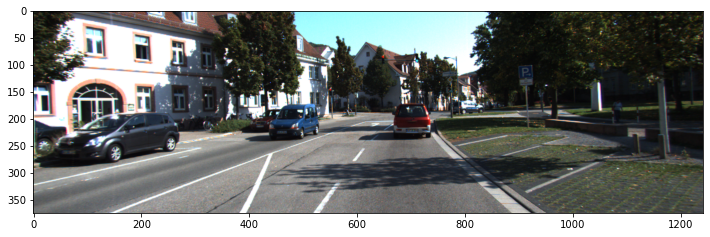

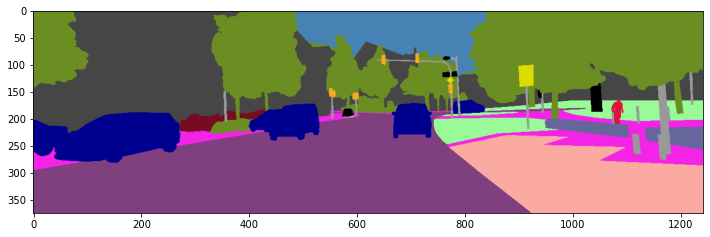

In [3]:
plt.imshow(plt.imread(images_path_train[0]))
plt.show()

plt.imshow(plt.imread(labels_path_train[0]))
plt.show()

## Color Class Association

For a better visualisation the classes of the segmented image are colorized. That means, each class is associated with a certain color. The association between the color and the classes is stored in the following dictionary. It contains the mapping from RGB color code to the class ID

In [4]:
rgb_to_class_id = {
    (128, 64, 128):  0,   # Road
    (244, 35, 232):  1,   # Sidewalk
    (250, 170, 160): 2,   # Parking
    (230, 150, 140): 3,   # Tail track
    (220,  20,  60): 4,   # Person
    (255,   0,   0): 5,   # Rider
    (  0,   0, 142): 6,   # Car
    (  0,   0,  70): 7,   # Truck
    (  0,  60, 100): 8,   # Bus
    (  0,  80, 100): 9,   # On Rails
    (  0,   0, 230): 10,  # Motorcycle
    (119,  11,  32): 11,  # Bicycle
    (  0,   0,  90): 12,  # Caravan
    (  0,   0, 110): 13,  # Trailer
    ( 70,  70,  70): 14,  # Building
    (102, 102, 156): 15,  # Wall
    (190, 153, 153): 16,  # Fence
    (180, 165, 180): 17,  # Guard Rail
    (150, 100, 100): 18,  # Bridge
    ( 50, 120,  90): 19,  # Tunnel
    (153, 153, 153): 20,  # Pole
    (220, 220,   0): 21,  # Traffic sign
    (250, 170,  30): 22,  # Traffic light
    (107, 142,  35): 23,  # Vegetation
    (152, 251, 152): 24,  # Terrain
    ( 70, 130, 180): 25,  # Sky
    ( 81,   0,  81): 26,  # Ground
    (111,  74,   0): 27,  # Dynamic
    ( 20,  20,  20): 28,  # Static
    (  0,   0,   0): 29   # None
}

## RGB label image into a segmentation map

The following function converts the RBG encoding into a segmentation map

In [5]:
def convert_rgb_encoding_to_segmentation_map(image, rgb_to_class_id):
    """
    Converts an image with the RGB class encoding into a class map.
    
    Argument:
    image -- tf.tensor of shape [heigh, width, 3] which contains for each pixel a tuple of (R, G, B) values.
    
    Returns:
    class_map -- tf.tensor of shape [heigh, width, 1] which contains for each pixel a single integer that represents a class
    """

    segmentation_map = tf.zeros([image.shape[0], image.shape[1]], dtype=tf.uint8)

    for color, class_id in rgb_to_class_id.items():    
    
        segmentation_map = tf.where(
                                    condition=tf.reduce_all(tf.equal(image, color), axis=-1),
                                    x=tf.cast(class_id, tf.uint8),                            
                                    y=segmentation_map                                      
                                    )
        
    # Add dimension to change the shape from [height, width] to [height, width, 1]
    segmentation_map = tf.expand_dims(segmentation_map, -1) 

        
    return segmentation_map

# Input Pipeline

## Parse sample

In [6]:
def parse_sample(image_path, label_path):
    """
    Argument:
    image_path -- String which contains the path to the camera image
    label_path -- String which contains the path to the label image
    
    Returns:
    image_rgb -- tf.Tensor of size [368, 1248, 3] containing the camera image
    label_segmentation_map -- tf.Tensor of size [368, 1248, 1] containing the segmentation map
    """
    image_rgb = tf.image.decode_png(tf.io.read_file(image_path), channels=3)  # image_rgb = None
    label_rgb = tf.image.decode_png(tf.io.read_file(label_path), channels=3)  # label_rgb = None
    
    
    # Resize all images and labels to a uniform size, because some images in the dataset have different sizes
    image_rgb = tf.image.resize(image_rgb, [368, 1248], method=tf.image.ResizeMethod.BILINEAR) 
    label_rgb = tf.image.resize(label_rgb, [368, 1248], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    # resize returns tf.float32 for BILINEAR, convert back to tf.uint8
    image_rgb = tf.cast(image_rgb, tf.uint8) 
    
    # apply convert_rgb_encoding_to_segmentation_map to the label_rgb image
    label_segmentation_map = convert_rgb_encoding_to_segmentation_map(label_rgb, rgb_to_class_id)
    
    return image_rgb, label_segmentation_map

## Data Normalization

In [7]:
def normalize(image, label):
    """
    Normalizes the input image from range [0, 255] to [0, 1.0]
    Arguments:
    image -- tf.tensor representing a RGB image with integer values in range [0, 255] 
    label -- tf.tensor representing the corresponding segmentation mask
    
    Returns:
    image -- tf.tensor representing a RGB image with integer values in range [0, 1] 
    label -- tf.tensor representing the corresponding segmentation mask
    """
    image = tf.cast(image, tf.float32) / 255.0 
    
    return image, label

# Dataset Creation

In [8]:
def create_dataset(images_path, labels_path, batch_size=4, buffer_size=200):
    """
    Arguments:
    images_path -- List of Strings which contain pathes for the camera images
    labels_pathh -- List of Strings which contain pathes for the label images
    
    Returns:
    dataset -- tf.data.Dataset
    """
    
    # Create tf.data.Dataset from images_path and labels_path, replace both None placeholders
    dataset = tf.data.Dataset.from_tensor_slices((images_path, labels_path)) 
    # Shuffle the dataset with buffer_size
    dataset = dataset.shuffle(buffer_size=buffer_size)                    
    # Apply the parse_sample function. Use tf.data.AUTOTUNE for the number of parallel calls
    dataset = dataset.map(parse_sample, num_parallel_calls=tf.data.AUTOTUNE) 
    # Apply data normalization. Use tf.data.AUTOTUNE for the number of parallel calls
    dataset = dataset.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)     
    # Apply batching to the dataset using batch_size
    dataset = dataset.batch(batch_size=batch_size)                           
    # Use prefetching 
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)                 

    return dataset

## Train-Valid Split

In [9]:
# get number of data samples
length = len(images_path_train)

train_size = round(length*0.7) 

In [10]:
train = create_dataset(images_path_train[:train_size], labels_path_train[:train_size])
val = create_dataset(images_path_train[train_size:], labels_path_train[train_size:])

In [11]:
print("Train Dataset Length:", tf.data.experimental.cardinality(train).numpy())
print("Val Dataset Length:", tf.data.experimental.cardinality(val).numpy())

Train Dataset Length: 35
Val Dataset Length: 15


## Model Architecture

U-Net, as described in this [paper](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/)

In [12]:
def encoder(input,
            udepth,
            filters1,
            kernel_size,
            activation,
            batch_norm,
            dropout):

    t = input
    encoder_layers = udepth * [None]

    # layer creation with successive pooling
    for d in range(udepth):
        filters = (2**d) * filters1
        t = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   padding="same",
                   activation=activation)(t)
        t = BatchNormalization()(t) if batch_norm else t
        t = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   padding="same",
                   activation=activation)(t)
        t = encoder_layers[d] = BatchNormalization()(t) if batch_norm else t
        if d < (udepth - 1):
            t = MaxPooling2D(pool_size=(2, 2), padding="same")(t)
            t = Dropout(rate=dropout)(t) if dropout > 0 else t

    return encoder_layers


def decoder(encoder_layers,
            udepth,
            filters1,
            kernel_size,
            activation,
            batch_norm,
            dropout):

    # start at lowest encoder layer
    t = encoder_layers[udepth - 1]

    # layer expansion symmetric to encoder
    for d in reversed(range(udepth - 1)):
        filters = (2**d) * filters1
        t = Conv2DTranspose(filters=filters,
                            kernel_size=kernel_size,
                            strides=(2, 2),
                            padding="same")(t)

        t = Concatenate()([encoder_layers[d], t])
        t = Dropout(rate=dropout)(t) if dropout > 0 else t
        t = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   padding="same",
                   activation=activation)(t)
        t = BatchNormalization()(t) if batch_norm else t
        t = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   padding="same",
                   activation=activation)(t)
        t = BatchNormalization()(t) if batch_norm else t

    return t

In [13]:
def getModel(input_shape,
             num_classes,
             udepth=5,
             filters1=16,
             kernel_size=(3, 3),
             activation=tf.nn.relu,
             batch_norm=True,
             dropout=0.1):
    """
    This function assembles the U-Net architecture and returns a Keras model which can be trained, saved and loaded.
    
    Arguments:
    input_shape -- Input shape of the model as tuple or list
    num_classes -- Number of classes to predict as int
    udepth -- Depth of the network
    filters1 -- Number of filters at the first layer
    kernel_size -- Kernel size for the convolutional operations
    activation -- Type of the Activation function
    batch_norm -- Boolean if batch norm should be applied
    dropout -- Dropout regularization  
    
    Returns:
    segmentation_model -- Keras Model
    """
    
    ### START CODE HERE ### 
    
    # create input layer
    input_tensor = Input(input_shape)  # input_tensor = None

    # construct encoder
    encoder_layers = encoder(input=input_tensor,     # input=None,
                             udepth=udepth,          # udepth=None,
                             filters1=filters1,      # filters1=None,
                             kernel_size=kernel_size,# kernel_size=None,
                             activation=activation,  # activation=None,
                             batch_norm=batch_norm,  # batch_norm=None,
                             dropout=dropout         # dropout=None
                            )

    # construct decoder
    reconstruction = decoder(encoder_layers=encoder_layers, # encoder_layers=None,
                             udepth=udepth,                 # udepth=None,
                             filters1=filters1,             # filters1=None,
                             kernel_size=kernel_size,       # kernel_size=None,
                             activation=activation,         # activation=None,
                             batch_norm=batch_norm,         # batch_norm=None,
                             dropout=dropout                # dropout=None
                            )

    # build final prediction layer
    logits = Conv2D(filters=num_classes,                    # filters=None
                    kernel_size=kernel_size,
                    padding="same",
                    activation=activation)(reconstruction)  # activation=activation)(None)
    
    # apply softmax activation function to the logits 
    probabilities = Activation("softmax")(logits)           # probabilities = None
    
    # create a Keras model
    segmentation_model = Model(inputs=input_tensor, outputs=probabilities)   # segmentation_model = Model(inputs=None, outputs=None)
    
    ### END CODE HERE ###
    
    return segmentation_model

In [14]:
model = getModel(input_shape=[368, 1248, 3], num_classes=30)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 368, 1248,   0           []                               
                                3)]                                                               
                                                                                                  
 conv2d (Conv2D)                (None, 368, 1248, 1  448         ['input_1[0][0]']                
                                6)                                                                
                                                                                                  
 batch_normalization (BatchNorm  (None, 368, 1248, 1  64         ['conv2d[0][0]']                 
 alization)                     6)                                                            

## Training

In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="sparse_categorical_crossentropy",
              metrics=[SparseMeanIoU(num_classes=30, name="MIoU")])

In [16]:
history = model.fit(train, validation_data=val, epochs=30)

Epoch 1/30
35/35 [==============================] - 26s 337ms/step - loss: 2.2415 - MIoU: 0.0632 - val_loss: 8.8303 - val_MIoU: 0.0240
Epoch 2/30
35/35 [==============================] - 12s 329ms/step - loss: 1.3607 - MIoU: 0.0949 - val_loss: 34.0128 - val_MIoU: 0.0105
Epoch 3/30
35/35 [==============================] - 12s 331ms/step - loss: 1.1792 - MIoU: 0.1067 - val_loss: 22.1099 - val_MIoU: 0.0089
Epoch 4/30
35/35 [==============================] - 12s 328ms/step - loss: 1.1003 - MIoU: 0.1156 - val_loss: 20.2975 - val_MIoU: 0.0092
Epoch 5/30
35/35 [==============================] - 12s 332ms/step - loss: 1.0578 - MIoU: 0.1219 - val_loss: 11.3527 - val_MIoU: 0.0090
Epoch 6/30
35/35 [==============================] - 12s 330ms/step - loss: 0.9808 - MIoU: 0.1286 - val_loss: 8.4436 - val_MIoU: 0.0089
Epoch 7/30
35/35 [==============================] - 12s 330ms/step - loss: 0.9085 - MIoU: 0.1327 - val_loss: 6.5305 - val_MIoU: 0.0094
Epoch 8/30
35/35 [==============================] -

## Saving Model

In [17]:
 model.save('saved_model/model')

INFO:tensorflow:Assets written to: saved_model/model/assets


INFO:tensorflow:Assets written to: saved_model/model/assets


## Model Loading

In [18]:
model.load_weights("saved_model/model/")

## Model inference

In [19]:
image, label = parse_sample(images_path_train[-1], labels_path_train[-1])
image, label = normalize(image, label)

# add batch dimension
image = tf.expand_dims(image, axis=0)

probabilities = model.predict(image)

print("Input Image Shape:  ", image.shape)
print("Probabilities Shape:", probabilities.shape)

1/1 [==============================] - 1s 1s/step
Input Image Shape:   (1, 368, 1248, 3)
Probabilities Shape: (1, 368, 1248, 30)


## segmentation map from one-hot-encoding

In [20]:
# compute the segmentation map
prediction = tf.argmax(probabilities, axis=-1)
# get rid of the batch dimension
prediction = tf.squeeze(prediction)

## Plot of the segmentation map

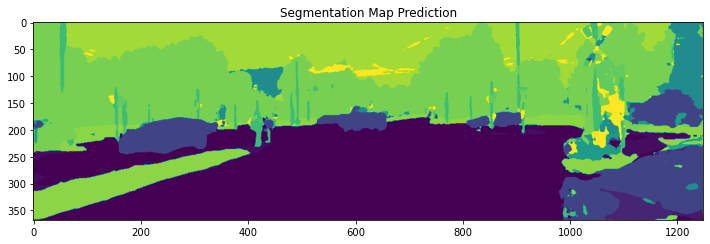

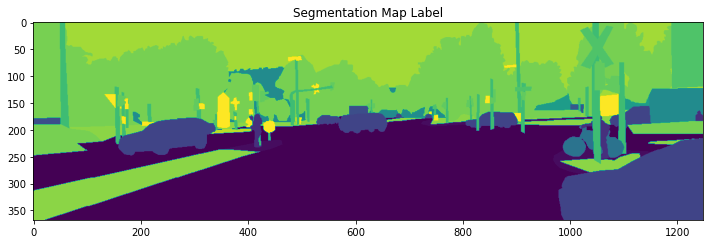

In [21]:
plt.figure()
plt.imshow(prediction)
plt.title("Segmentation Map Prediction")
plt.show()

plt.figure()
plt.imshow(label)
plt.title("Segmentation Map Label")
plt.show()

## segmentation_map_to_rgb_encoding

In [22]:
def segmentation_map_to_rgb_encoding(segmentation_map, rgb_to_class_id):
    """
    Converts the segmentation map into a RGB encoding
    
    Arguments:
    segmentation_map -- Numpy ndArray of shape [height, width, 1]
    rgb_to_class_id -- Dictionary which contains the association between color and class ID
    
    Returns:
    rgb_encoding -- Numpy ndArray of shape [height, width, 3]
    """

    rgb_encoding = np.zeros([segmentation_map.shape[0], segmentation_map.shape[1], 3], dtype=np.uint8)
    
    ### START CODE HERE ### 
    for color, class_id in rgb_to_class_id.items():       # for color, class_id in None:
        
        rgb_encoding[segmentation_map==class_id] = color  # rgb_encoding[None==None] = None
    
    ### END CODE HERE ###
    return rgb_encoding

RGB Encoding shape: (368, 1248, 3)


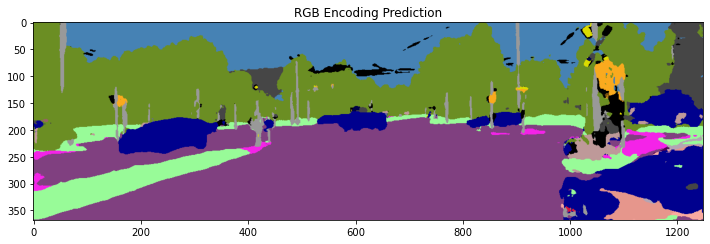

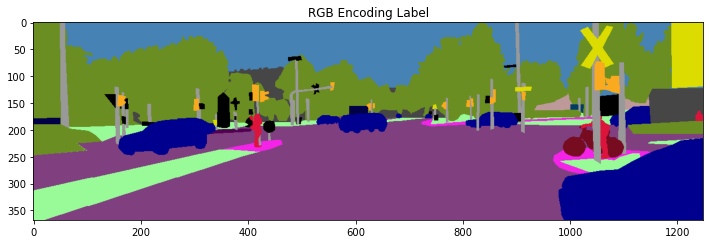

In [23]:
rgb_encoding = segmentation_map_to_rgb_encoding(prediction, rgb_to_class_id)

print("RGB Encoding shape:", rgb_encoding.shape)

plt.figure(figsize=(12, 12))
plt.imshow(rgb_encoding)
plt.title("RGB Encoding Prediction")
plt.show()


rgb_encoding = segmentation_map_to_rgb_encoding(np.squeeze(label), rgb_to_class_id)

plt.figure(figsize=(12, 12))
plt.imshow(rgb_encoding)
plt.title("RGB Encoding Label")
plt.show()

## Define Feature map extraction function

Feature map extraction code is inspired by [this blog](https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/)

In [24]:
input_image, label = parse_sample(images_path_train[-1], labels_path_train[-1])
input_image, label = normalize(input_image, label)

# add batch dimension
input_image = tf.expand_dims(input_image, axis=0)

In [25]:
def save_feature_maps(model, input_image, layer_number, num_channels):
    # Define the layer model
    layer_model = Model(inputs=model.inputs, outputs=model.layers[layer_number].output)
    layer_model.summary()
    
    # Get the activations of the specified layer
    layer_activations = layer_model.predict(input_image)
    layer_activations = layer_activations.squeeze()
    
    # Create a directory to save the images
    output_dir = f"feature_maps_layer_{layer_number}"
    os.makedirs(output_dir, exist_ok=True)
    
    # Iterate over each channel and save the images
    for i in range(num_channels):
        fig, ax = plt.subplots()
        ax.imshow(layer_activations[..., i], cmap='gray')
        ax.set_title(f'Channel {i+1}')
        plt.axis('off')  # Turn off axis
        plt.savefig(os.path.join(output_dir, f'channel_{i+1}.png'), bbox_inches='tight', pad_inches=0)
        plt.close(fig)  # Close the figure to release memory
    
    print(f"Images for layer {layer_number} saved successfully.")

## Save Feature Maps

Set the layer number and the corresponding number of channels to save the feature maps for the corresponding layer. Note, the first conv2d layer is the layer number 1.

In [26]:
# Assuming model is your CNN model and input_image is the input image
save_feature_maps(model, input_image, layer_number=7, num_channels=32)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 368, 1248, 3)]    0         
                                                                 
 conv2d (Conv2D)             (None, 368, 1248, 16)     448       
                                                                 
 batch_normalization (BatchN  (None, 368, 1248, 16)    64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 368, 1248, 16)     2320      
                                                                 
 batch_normalization_1 (Batc  (None, 368, 1248, 16)    64        
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 184, 624, 16)     0   

## References

#### Kitti Dataset

#### U-Net Architecture

#### ika ACDC Notebooks

https://github.com/ika-rwth-aachen/acdc-notebooks/tree/8afe3197db454e2aabd381fb5fc7d22a98f2b23f

Machine Learning Mastery

https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/